In [ ]:
# Import statements and main classes - with module reload for development
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pickle
from tqdm import tqdm
import importlib

# Import and reload modules to pick up changes
from celara import KeplerLCPreprocessor, KeplerFeatureExtractor
from celara_utils import *
from celara_model import *

/home/kareem/Nasa_25-26/nasa_25-26/venv/lib/python3.10/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(
2025-10-05 15:59:53.363424: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-05 15:59:53.668386: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-05 15:59:53.363424: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-05 15:59:53.668386: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized t

✅ Modules reloaded with latest lightweight architecture changes!


/home/kareem/Nasa_25-26/nasa_25-26/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Parameters
DATA_PATH = "data" # Relative path to data directory
os.makedirs(DATA_PATH, exist_ok=True)

# Check if KOI data already downloaded. Set to False to force re-download.
KOI_DOWNLOADED_ALREADY = os.path.exists(f"{DATA_PATH}/kepler_koi_dr25.csv") 

# Scale up for meaningful ML results - 1000+ samples needed
LIGHT_CURVES_TO_DOWNLOAD = 1000  # Scaled up from 100 for proper training!
BALANCED_SUBSET_DOWNLOADED = os.path.exists(f"{DATA_PATH}/koi_balanced_subset.csv")

# 1.Load Data (KOI, Lightcurves)

In [3]:
# Download KOI (Kepler Objects of Interest ie stars) catalog from NASA Exoplanet Archive using TAP service
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+q1_q17_dr25_koi&format=csv"


if not KOI_DOWNLOADED_ALREADY and not BALANCED_SUBSET_DOWNLOADED:
    koi_df = pd.read_csv(url)
    koi_df.to_csv(f"{DATA_PATH}/kepler_koi_dr25.csv", index=False)
else:
    koi_df = pd.read_csv(f"{DATA_PATH}/kepler_koi_dr25.csv")

koi_df.head()

,kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,...,koi_fpflag_co,koi_fpflag_ec,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_score
0,10811496,K00753.01,NaN,297.00482,0.0,19h48m01.16s,48.134129,0.0,+48d08m02.9s,15.943,...,0,0,39.30,31.04,-10.49,7.29555,35.03293,-2.75453,LS+MCMC,0.0
1,10848459,K00754.01,NaN,285.53461,0.0,19h02m08.31s,48.285210,0.0,+48d17m06.8s,16.100,...,0,0,891.96,668.95,-230.35,0.22080,0.00917,-0.01837,LS+MCMC,0.0
2,10854555,K00755.01,Kepler-664 b,288.75488,0.0,19h15m01.17s,48.226200,0.0,+48d13m34.3s,16.015,...,0,0,926.16,874.33,-314.24,1.98635,2.71141,-1.74541,LS+MCMC,1.0
3,10872983,K00756.01,Kepler-228 d,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,114.81,112.85,-36.70,0.67324,0.33286,-0.38858,LS+MCMC,1.0
4,10872983,K00756.02,Kepler-228 c,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,427.65,420.33,-136.70,0.37377,0.74768,-0.26357,LS+MCMC,1.0


In [4]:
# Keep only confirmed planets and false positives
removed_candidates = koi_df[~koi_df["koi_disposition"].isin(["CONFIRMED", "FALSE POSITIVE"])]
koi_df = koi_df[koi_df["koi_disposition"].isin(["CONFIRMED", "FALSE POSITIVE"])].copy()

# Map to numeric labels
label_map = {"CONFIRMED": 1, "FALSE POSITIVE": 0}
koi_df["label"] = koi_df["koi_disposition"].map(label_map)

print("Removed candidates (not confirmed or false positive):", removed_candidates.shape[0])
print(koi_df["koi_disposition"].value_counts())
print("Labeled dataset ready, shape:", koi_df.shape)
koi_df.to_csv(f"{DATA_PATH}/kepler_koi_dr25_cleaned.csv", index=False)

Removed candidates (not confirmed or false positive): 1360
koi_disposition
FALSE POSITIVE    3965
CONFIRMED         2729
Name: count, dtype: int64
Labeled dataset ready, shape: (6694, 154)


In [5]:
# Download N light curves with balanced sampling (equal confirmed/false positives)
# This ensures class balance for machine learning training
if LIGHT_CURVES_TO_DOWNLOAD == 0:
    if os.path.exists(f"{DATA_PATH}/lightcurves"):
        print(f"\nLightcurves already downloadeded and expected at '{DATA_PATH}/lightcurves', skipping download step.")
    else:
        print(f"\nLightcurves download flag is set, but {DATA_PATH}/lightcurves does not exist. Please check.")
else:
    # Calculate balanced sample sizes
    confirmed = koi_df[koi_df["koi_disposition"] == "CONFIRMED"]
    false_positive = koi_df[koi_df["koi_disposition"] == "FALSE POSITIVE"]

    # Take equal numbers from each class (half of LIGHT_CURVES_TO_DOWNLOAD each)
    samples_per_class = LIGHT_CURVES_TO_DOWNLOAD // 2

    print(f"Available data:")
    print(f"  Confirmed planets: {len(confirmed)}")
    print(f"  False positives: {len(false_positive)}")
    print(f"\nBalanced sampling:")
    print(f"  Taking {samples_per_class} from each class = {samples_per_class * 2} total")

    # Sample equal numbers from each class
    confirmed_sample = confirmed.sample(samples_per_class, random_state=42)
    fp_sample = false_positive.sample(samples_per_class, random_state=42)

    # Combine and shuffle
    balanced_subset = pd.concat([confirmed_sample, fp_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

    # Verify balance
    print(f"\nBalanced subset verification:")
    print(balanced_subset["koi_disposition"].value_counts())
    print(f"Total samples: {len(balanced_subset)}")

    # Save balanced subset for model training phase
    balanced_subset.to_csv("data/koi_balanced_subset.csv", index=False)
    print(f"Saved balanced dataset: data/koi_balanced_subset.csv")

    # Download lightcurves for balanced subset
    subset_results = fetch_lightcurves(balanced_subset["kepid"].tolist(), sleep=1, overwrite=False)
    print(f"\nDownload results:")
    print(subset_results["success"].value_counts())
    if "error" in subset_results.columns:
        print("Error breakdown:")
        print(subset_results['error'].value_counts())

Available data:
  Confirmed planets: 2729
  False positives: 3965

Balanced sampling:
  Taking 50 from each class = 100 total

Balanced subset verification:
koi_disposition
FALSE POSITIVE    50
CONFIRMED         50
Name: count, dtype: int64
Total samples: 100
Saved balanced dataset: data/koi_balanced_subset.csv


Fetching Kepler light curves: 100%|██████████| 100/100 [16:00<00:00,  9.60s/it]


Download results:
success
True     92
False     8
Name: count, dtype: int64
Error breakdown:
error
The transaction was terminated because of the availability replica config/state change or because ghost records are being deleted on the primary and the secondary availability replica that might be needed by queries running under snapshot isolation. Retry the transaction.    8
Name: count, dtype: int64


# 2. Processing (Masking, normalisation, detrending, feature extraction)

In [6]:
# Process dataset to extract features
# This includes loading light curves, preprocessing, and feature extraction
# Results saved to .npz files for easy loading in ML frameworks

# Use consistent variable names
lightcurve_dir = f"{DATA_PATH}/lightcurves"

# Determine which dataset to use (balanced_subset if available)
if 'balanced_subset' in locals():
    dataset_to_process = balanced_subset
    print(f"Using balanced_subset: {dataset_to_process.shape}")
    print(f"Class balance: {dataset_to_process['koi_disposition'].value_counts().to_dict()}")
else:
    print("❌ No balanced_subset found. Run cell 6 first to create balanced dataset.")
    dataset_to_process = None

if dataset_to_process is not None:
    # Run processing on the balanced dataset
    print(f"\n🔧 Processing {len(dataset_to_process)} samples from balanced dataset...")
    X, y = process_kepler_dataset(dataset_to_process, lightcurve_dir, path=DATA_PATH, save_name="features_balanced")

    if X is not None:
        print(f"\n📊 Processing Results:")
        print(f"   Features shape: {X.shape}")
        print(f"   Labels: {np.bincount(y)} (0=FP, 1=Confirmed)")
        print(f"   Ready for neural network training!")
        
        # To process only a subset for demo, use:
        # X_demo, y_demo = process_kepler_dataset(dataset_to_process, lightcurve_dir, max_samples=3, path=DATA_PATH, save_name="features_demo")
else:
    print("Cannot process - no dataset available")

Using balanced_subset: (100, 154)
Class balance: {'FALSE POSITIVE': 50, 'CONFIRMED': 50}

🔧 Processing 100 samples from balanced dataset...
Processing 100 samples from dataset...


Building file index: 100%|██████████| 99/99 [00:00<00:00, 411532.31it/s]


File index: 99 files
Available lightcurves: 100/100


Processing lightcurves: 100%|██████████| 100/100 [00:20<00:00,  4.77it/s]

✅ Successfully processed 100 samples
   Shape: (100, 2206)
   Labels: [50 50] (0=FP, 1=Confirmed)
   Saved: data/features_balanced.npz

📊 Processing Results:
   Features shape: (100, 2206)
   Labels: [50 50] (0=FP, 1=Confirmed)
   Ready for neural network training!


# 3. Multi-Modal ResNet Model

In [28]:
# Create the LIGHTWEIGHT AstroNet with ResNet + all 3 feature types
model = create_astronet_resnet_trimodal()

# Display model architecture
model.summary()

# Generate model diagram
try:
    tf.keras.utils.plot_model(
        model, 
        show_shapes=True, 
        show_layer_names=True, 
        to_file='models/architectures/astronet_resnet_lightweight_architecture.png', 
        dpi=150,
        rankdir='TB'
    )
    print("✅ AstroNet-ResNet-Lightweight architecture saved to 'models/architectures/astronet_resnet_lightweight_architecture.png'")

except Exception as e:
    print(f"⚠️  Plot failed: {e}")
    
print(f"   Architecture: AstroNet + Simple ResNet + Global Average Pooling")
print(f"   Input 1: Local view (201 transit features)")  
print(f"   Input 2: Global view (2001 orbital features)")
print(f"   Input 3: Auxiliary features (4 stellar parameters)")
print(f"   Output: Single planet probability")
print(f"\nReady for efficient training with all 3 feature types!")

Model: "AstroNet_ResNet_Lightweight"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ global_view         │ (None, 2001)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 2001, 1)   │          0 │ global_view[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 2001, 16)  │         96 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 200, 16)   │          0 │ conv1d_26[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 200, 32)   │      2,592 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ local_view          │ (None, 201)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 200, 32)   │      5,152 │ conv1d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 200, 32)   │        544 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 201, 1)    │          0 │ local_view[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 200, 32)   │          0 │ conv1d_28[0][0],  │
│                     │                   │            │ conv1d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 201, 16)   │         96 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 200, 32)   │          0 │ add_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 40, 16)    │          0 │ conv1d_22[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 40, 32)    │          0 │ re_lu_7[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 40, 32)    │      2,592 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 40, 64)    │     10,304 │ max_pooling1d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 40, 32)    │      5,152 │ conv1d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 40, 32)    │        544 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 40, 64)    │     20,544 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 40, 64)    │      2,112 │ max_pooling1d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 40, 32)    │          0 │ conv1d_24[0][0],  │
│                     │                   │            │ conv1d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 71,529 (279.41 KB)

 Trainable params: 71,529 (279.41 KB)

 Non-trainable params: 0 (0.00 B)

✅ AstroNet-ResNet-Lightweight architecture saved to 'models/architectures/astronet_resnet_lightweight_architecture.png'
   Architecture: AstroNet + Simple ResNet + Global Average Pooling
   Input 1: Local view (201 transit features)
   Input 2: Global view (2001 orbital features)
   Input 3: Auxiliary features (4 stellar parameters)
   Output: Single planet probability

Ready for efficient training with all 3 feature types!


In [27]:
# Load and prepare data for training
print("📊 Loading processed features...")

# Load your processed features
data = np.load(f'{DATA_PATH}/features_balanced.npz')
X_full, y_full = data['X'], data['y']

print(f"Loaded data shape: {X_full.shape}, Labels: {y_full.shape}")
print(f"Class distribution: {np.bincount(y_full)} (0=False Positive, 1=Confirmed)")

# Split features into modalities
print("\n🔧 Splitting features into modalities...")
local_features = X_full[:, :201]           # Transit region (201 features)
global_features = X_full[:, 201:2202]     # Full orbital (2001 features)
aux_features = X_full[:, 2202:]            # Stellar parameters (4 features)

# Train/validation/test split
print("\n📂 Creating train/validation/test splits...")
# First split: 80% train+val, 20% test
X_local_temp, X_local_test, X_global_temp, X_global_test, X_aux_temp, X_aux_test, y_temp, y_test = train_test_split(
    local_features, global_features, aux_features, y_full, 
    test_size=0.2, stratify=y_full, random_state=42
)

# Second split: 60% train, 40% val (from the 80%)
X_local_train, X_local_val, X_global_train, X_global_val, X_aux_train, X_aux_val, y_train, y_val = train_test_split(
    X_local_temp, X_global_temp, X_aux_temp, y_temp, 
    test_size=0.4, stratify=y_temp, random_state=42
)

print(f"Training set: {X_local_train.shape[0]} samples")
print(f"Validation set: {X_local_val.shape[0]} samples") 
print(f"Test set: {X_local_test.shape[0]} samples")

print("\n✅ Data prepared for training!")

📊 Loading processed features...
Loaded data shape: (100, 2206), Labels: (100,)
Class distribution: [50 50] (0=False Positive, 1=Confirmed)

🔧 Splitting features into modalities...

📂 Creating train/validation/test splits...
Training set: 48 samples
Validation set: 32 samples
Test set: 20 samples

✅ Data prepared for training!


In [26]:
# Model compilation and training - No class weights
print("⚙️  Compiling model...")

# Training parameters
epochs = 100
batch_size = 32
steps_per_epoch = len(X_local_train) // batch_size
total_steps = epochs * steps_per_epoch
warmup_steps = total_steps // 20  # 5% warmup

# Conservative learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=total_steps - warmup_steps,
    alpha=1e-6,
    warmup_target=1e-3,
    warmup_steps=warmup_steps
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.AUC(curve='PR', name='pr_auc')]
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min'),
    tf.keras.callbacks.ModelCheckpoint('models/keras/best_exoplanet_model.keras', monitor='val_loss', 
                                       save_best_only=True, mode='min')
]

print("\n🚀 Starting training...")

# Train the model without class weights
history = model.fit(
    [X_local_train, X_global_train, X_aux_train],
    y_train,
    validation_data=([X_local_val, X_global_val, X_aux_val], y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")

⚙️  Compiling model...

🚀 Starting training...
Epoch 1/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.5312 - auc: 0.4615 - loss: 4.0194 - pr_auc: 0.3500 - precision: 0.4375 - recall: 0.5385WARNING:tensorflow:5 out of the last 114 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x70e4f51a4790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 870ms/step - accuracy: 0.5208 - auc: 0.4540 - loss: 3.0705 - pr_a

📈 Training History:


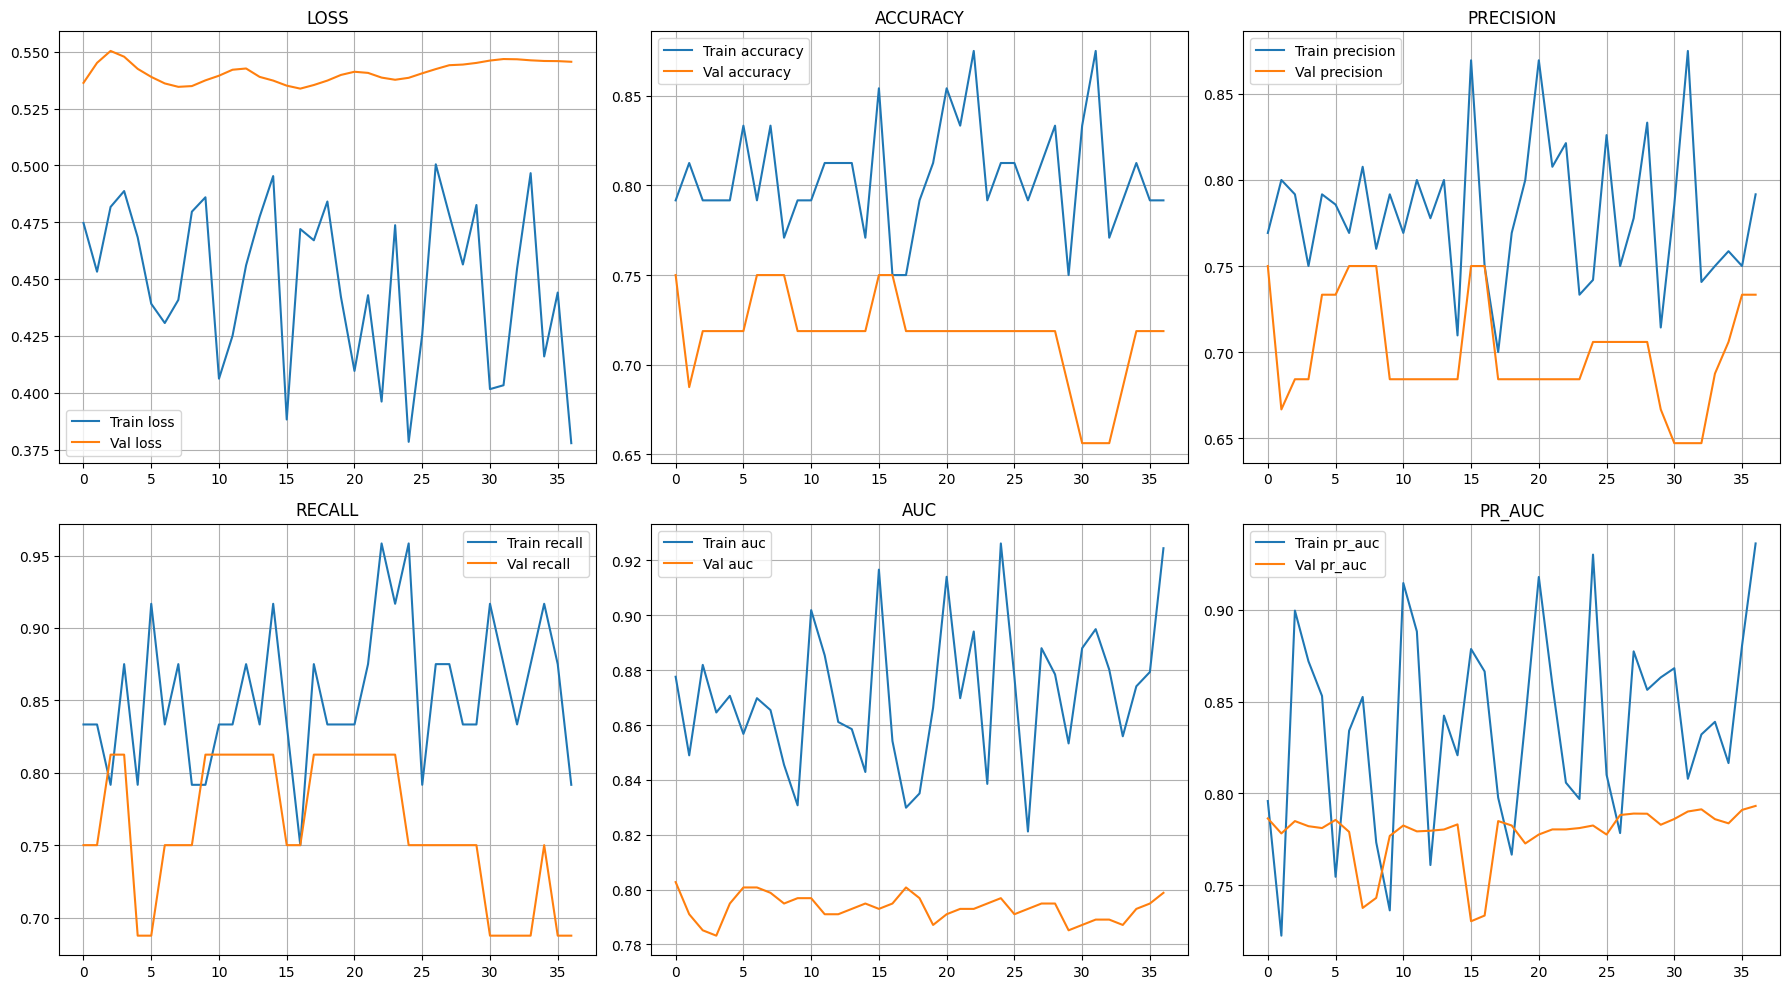


🏆 Loading best model...

🧪 Evaluating on test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step

📊 Classification Report:
                  precision    recall  f1-score   support

  False Positive       0.71      0.50      0.59        10
Confirmed Planet       0.62      0.80      0.70        10

        accuracy                           0.65        20
       macro avg       0.66      0.65      0.64        20
    weighted avg       0.66      0.65      0.64        20


🔍 Confusion Matrix:
[[5 5]
 [2 8]]

🎯 Final Test Metrics:
   Accuracy: 0.6500
   Precision: 0.6154
   Recall: 0.8000
   ROC-AUC: 0.6250
   PR-AUC: 0.6279


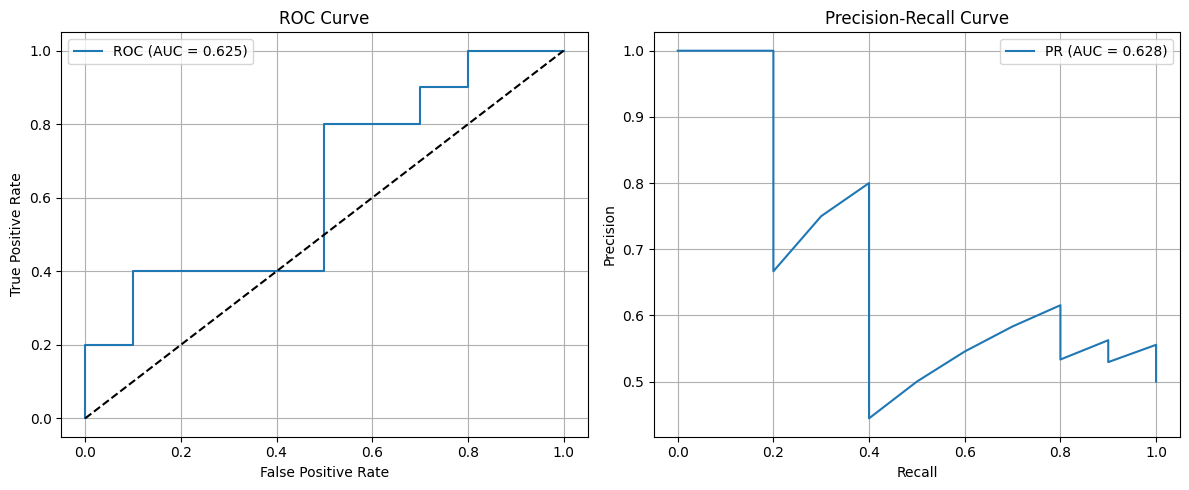


✅ Model evaluation complete!


In [23]:
# Training visualization and evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve

# Plot training history
def plot_training_history(history):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc', 'pr_auc']
    
    for i, metric in enumerate(metrics):
        row = i // 3
        col = i % 3
        
        axes[row, col].plot(history.history[metric], label=f'Train {metric}')
        axes[row, col].plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        axes[row, col].set_title(f'{metric.upper()}')
        axes[row, col].legend()
        axes[row, col].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
print("📈 Training History:")
plot_training_history(history)

# Load best model
print("\n🏆 Loading best model...")
best_model = tf.keras.models.load_model('models/keras/best_exoplanet_model.keras')

# Evaluate on test set - Using ALL 3 inputs
print("\n🧪 Evaluating on test set...")
test_predictions = best_model.predict([X_local_test, X_global_test, X_aux_test])  # All 3 inputs
test_pred_binary = (test_predictions > 0.5).astype(int).flatten()

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, test_pred_binary, 
                          target_names=['False Positive', 'Confirmed Planet']))

# Confusion matrix
print("\n🔍 Confusion Matrix:")
cm = confusion_matrix(y_test, test_pred_binary)
print(cm)

# Calculate final metrics - Using ALL 3 inputs
test_loss, test_acc, test_prec, test_rec, test_auc, test_pr_auc = best_model.evaluate(
    [X_local_test, X_global_test, X_aux_test], y_test, verbose=0  # All 3 inputs
)

print(f"\n🎯 Final Test Metrics:")
print(f"   Accuracy: {test_acc:.4f}")
print(f"   Precision: {test_prec:.4f}")
print(f"   Recall: {test_rec:.4f}")
print(f"   ROC-AUC: {test_auc:.4f}")
print(f"   PR-AUC: {test_pr_auc:.4f}")

# Plot ROC and PR curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_predictions)
ax1.plot(fpr, tpr, label=f'ROC (AUC = {test_auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend()
ax1.grid(True)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, test_predictions)
ax2.plot(recall, precision, label=f'PR (AUC = {test_pr_auc:.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\n✅ Model evaluation complete!")